Tile Information:
CRS: EPSG:32631
Bounds: BoundingBox(left=400860.0, bottom=4885990.0, right=403440.0, top=4888580.0)
Size: 258 x 259

VRT Information:
VRT CRS: EPSG:2154
Original bounds: BoundingBox(left=400860.0, bottom=4885990.0, right=403440.0, top=4888580.0)
Transformed bounds: (600833.3735096335, 6336485.16199978, 603415.4695454484, 6339077.253581086)

Window Data Stats:
Shape: (258, 0)


/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_9362/3460953918.py:61: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(window_data)


ValueError: zero-size array to reduction operation minimum which has no identity

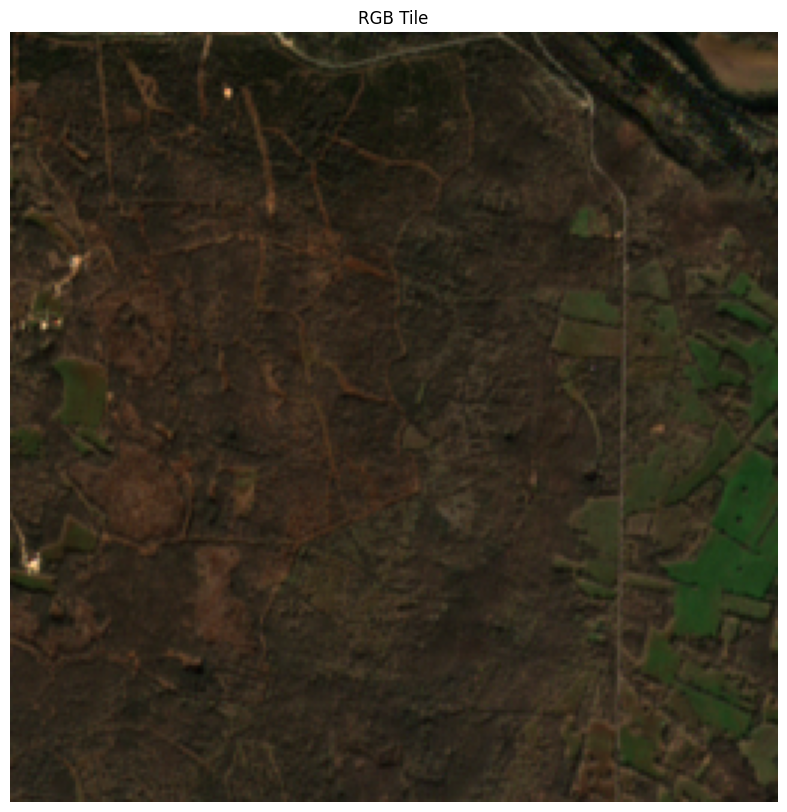

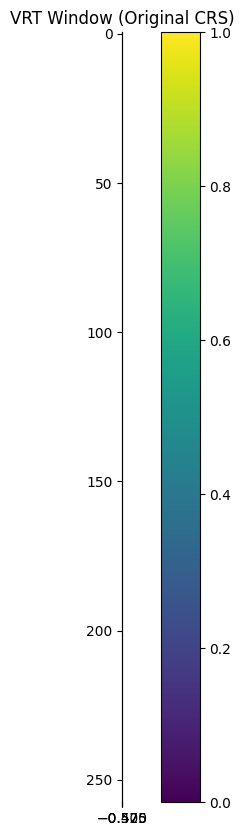

In [10]:
# Import required libraries
import rasterio
from rasterio.warp import transform_bounds, transform
from rasterio.windows import from_bounds
from rasterio.vrt import WarpedVRT
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os 
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

# 1. Select and display one tile's RGB image
tile_path = "/Users/arthurcalvi/Data/species/validation/tiles_2_5_km/tile_9_20201127_20240204_Sud-Ouest_océanique/rgb/"
files = os.listdir(tile_path)
file = [f for f in files if f.endswith('.tif')][0]
tile_path = os.path.join(tile_path, file)

vrt_path = "/Users/arthurcalvi/Data/species/HR-VPP/Results-2/VRT/france_mosaic.vrt"

# Load and display RGB
with rasterio.open(tile_path) as src:
    rgb = src.read()
    bounds = src.bounds
    tile_crs = src.crs
    tile_transform = src.transform
    tile_height = src.height
    tile_width = src.width
    
    # Display RGB
    plt.figure(figsize=(10, 10))
    plt.title("RGB Tile")
    plt.imshow(normalize(rgb.transpose(1, 2, 0)))
    plt.axis("off")
    
    print("Tile Information:")
    print(f"CRS: {tile_crs}")
    print(f"Bounds: {bounds}")
    print(f"Size: {tile_width} x {tile_height}")

# 2. Transform bounds to VRT CRS and display the window
with rasterio.open(vrt_path) as vrt_src:
    # Transform bounds
    vrt_bounds = transform_bounds(tile_crs, vrt_src.crs, *bounds)
    
    print("\nVRT Information:")
    print(f"VRT CRS: {vrt_src.crs}")
    print(f"Original bounds: {bounds}")
    print(f"Transformed bounds: {vrt_bounds}")
    
    # Create window
    window = from_bounds(*vrt_bounds, vrt_src.transform)
    
    # Read and display the window
    window_data = vrt_src.read(1, window=window)
    
    plt.figure(figsize=(10, 10))
    plt.title("VRT Window (Original CRS)")
    plt.imshow(window_data)
    plt.colorbar()
    
    print("\nWindow Data Stats:")
    print(f"Shape: {window_data.shape}")
    print(f"Min: {window_data.min()}")
    print(f"Max: {window_data.max()}")
    print(f"Mean: {window_data.mean()}")
    print(f"Unique values: {len(np.unique(window_data))}")

# 3. Reproject window to tile CRS
with rasterio.open(vrt_path) as vrt_src:
    # First create a VRT for the window
    with WarpedVRT(vrt_src,
                   crs=vrt_src.crs,
                   transform=vrt_src.transform,
                   window=window) as window_vrt:
        
        # Then create a VRT for reprojection
        with WarpedVRT(window_vrt,
                      crs=tile_crs,
                      transform=tile_transform,
                      width=tile_width,
                      height=tile_height) as warped_vrt:
            
            # Read the reprojected data
            reprojected_data = warped_vrt.read(1)
            
            plt.figure(figsize=(10, 10))
            plt.title("Reprojected Window (Tile CRS)")
            plt.imshow(reprojected_data)
            plt.colorbar()
            
            print("\nReprojected Data Stats:")
            print(f"Shape: {reprojected_data.shape}")
            print(f"Min: {reprojected_data.min()}")
            print(f"Max: {reprojected_data.max()}")
            print(f"Mean: {reprojected_data.mean()}")
            print(f"Unique values: {len(np.unique(reprojected_data))}")

# Display the three plots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# RGB tile
show(rgb, transform=tile_transform, ax=ax1)
ax1.set_title("RGB Tile")

# VRT window
ax2.imshow(window_data)
ax2.set_title("VRT Window")

# Reprojected data
ax3.imshow(reprojected_data)
ax3.set_title("Reprojected Window")

plt.tight_layout()
plt.show()

In [11]:
# Import required libraries
import rasterio
from rasterio.warp import transform_bounds
import numpy as np

# Debug Step 1: Just check basic information and bounds
def check_raster_info(path, name):
    """Print basic information about a raster file"""
    with rasterio.open(path) as src:
        print(f"\n{name} Information:")
        print(f"CRS: {src.crs}")
        print(f"Bounds: {src.bounds}")
        print(f"Transform: {src.transform}")
        print(f"Shape: {src.height} x {src.width}")
        return src.crs, src.bounds

def main():
    # Update these paths
    # Get info for both files
    tile_crs, tile_bounds = check_raster_info(tile_path, "Tile")
    vrt_crs, vrt_bounds = check_raster_info(vrt_path, "VRT")
    
    # Transform bounds
    vrt_bounds_transformed = transform_bounds(
        tile_crs, vrt_crs,
        tile_bounds.left, tile_bounds.bottom,
        tile_bounds.right, tile_bounds.top
    )
    
    print("\nBounds Transformation:")
    print(f"Original bounds: {tile_bounds}")
    print(f"Transformed bounds: {vrt_bounds_transformed}")
    
    # Check if transformed bounds are within VRT extent
    print("\nBounds Check:")
    in_x_bounds = vrt_bounds.left <= vrt_bounds_transformed[0] <= vrt_bounds.right and \
                 vrt_bounds.left <= vrt_bounds_transformed[2] <= vrt_bounds.right
    in_y_bounds = vrt_bounds.bottom <= vrt_bounds_transformed[1] <= vrt_bounds.top and \
                 vrt_bounds.bottom <= vrt_bounds_transformed[3] <= vrt_bounds.top
    
    print(f"X bounds within VRT extent: {in_x_bounds}")
    print(f"Y bounds within VRT extent: {in_y_bounds}")
    
    if not (in_x_bounds and in_y_bounds):
        print("\nWARNING: Transformed bounds outside VRT extent!")
        print(f"VRT bounds: {vrt_bounds}")
        print(f"Transformed bounds: {vrt_bounds_transformed}")

if __name__ == "__main__":
    main()


Tile Information:
CRS: EPSG:32631
Bounds: BoundingBox(left=400860.0, bottom=4885990.0, right=403440.0, top=4888580.0)
Transform: | 10.00, 0.00, 400860.00|
| 0.00,-10.00, 4888580.00|
| 0.00, 0.00, 1.00|
Shape: 259 x 258

VRT Information:
CRS: EPSG:2154
Bounds: BoundingBox(left=-493469.87358481716, bottom=5369737.105131679, right=173589.8807243636, top=7229355.141530664)
Transform: | 10.06, 0.00,-493469.87|
| 0.00,-10.06, 7229355.14|
| 0.00, 0.00, 1.00|
Shape: 184883 x 66319

Bounds Transformation:
Original bounds: BoundingBox(left=400860.0, bottom=4885990.0, right=403440.0, top=4888580.0)
Transformed bounds: (600833.3735096335, 6336485.16199978, 603415.4695454484, 6339077.253581086)

Bounds Check:
X bounds within VRT extent: False
Y bounds within VRT extent: True

VRT bounds: BoundingBox(left=-493469.87358481716, bottom=5369737.105131679, right=173589.8807243636, top=7229355.141530664)
Transformed bounds: (600833.3735096335, 6336485.16199978, 603415.4695454484, 6339077.253581086)
